In [ ]:
# finds which npm packages are most depended on by others using the top 5000 packages dataset
# combines regular and dev dependencies
# counts how many packages depend on each one
# saves the results in a csv file

In [14]:
import pandas as pd
from ast import literal_eval
from collections import defaultdict

# load the csv
df = pd.read_csv("top_5000_npm_packages.csv")

# turn text into a python list
def safe_parse(x):
    try:
        if pd.isna(x) or x == "[]":
            return []
        return literal_eval(str(x))
    except Exception:
        return []

# parse both dependency columns
df["dependencies_list"] = df["dependencies_list"].apply(safe_parse)
df["devDependencies_list"] = df["devDependencies_list"].apply(safe_parse)

# combine both into one master list
df["all_dependencies"] = df["dependencies_list"] + df["devDependencies_list"]

# build reverse mapping: dependency -> who depends on it
dependents = defaultdict(set)
for _, row in df.iterrows():
    pkg = row["package_name"]
    for dep in row["all_dependencies"]:
        dependents[dep].add(pkg)

# count direct dependents
dependents_count = pd.DataFrame(
    [(pkg, len(dependents[pkg])) for pkg in dependents],
    columns=["package_name", "num_direct_dependents"]
).sort_values("num_direct_dependents", ascending=False)

# keep only the top 500 packages
top_500 = dependents_count.head(5000)

# add rank column (1 most depended)
top_500 = top_500.reset_index(drop=True)  # reset old pandas index
top_500.insert(0, "rank", top_500.index + 1)  # add rank starting 1

# save the file
top_500.to_csv("direct_dependents_top500.csv", index=False)
top_500.head(500)

,rank,package_name,num_direct_dependents
0,1,eslint,1236
1,2,typescript,1154
2,3,mocha,1111
3,4,@types/node,740
4,5,prettier,713
...,...,...,...
495,496,deep-equal,16
496,497,vows,16
497,498,parse5,16
498,499,@pika/plugin-build-web,15


In [22]:
top_500[top_500['package_name'] == 'chalk']

,rank,package_name,num_direct_dependents
36,37,chalk,189


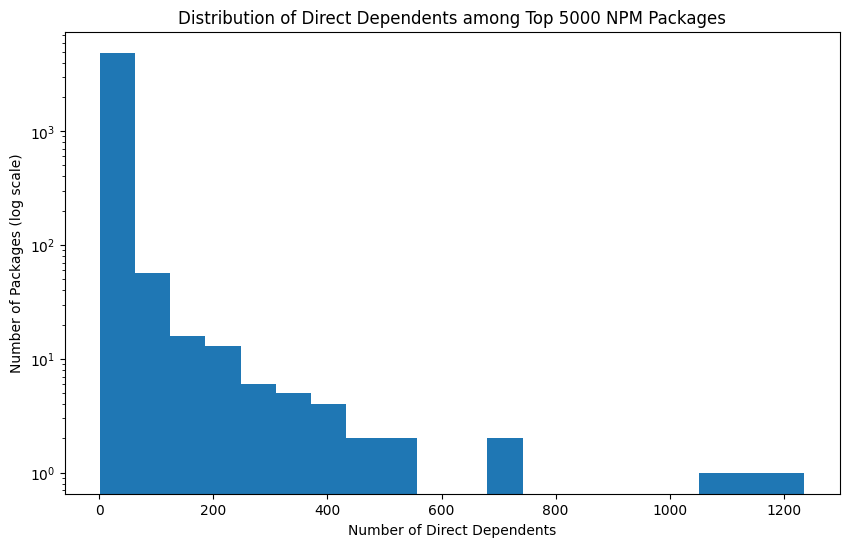

In [19]:
import matplotlib.pyplot as plt

dependents = pd.read_csv("direct_dependents_top500.csv")
plt.figure(figsize=(10,6))
plt.hist(dependents['num_direct_dependents'], bins=20)
plt.yscale('log')
plt.xlabel('Number of Direct Dependents')
plt.ylabel('Number of Packages (log scale)')
plt.title('Distribution of Direct Dependents among Top 5000 NPM Packages')
plt.show()


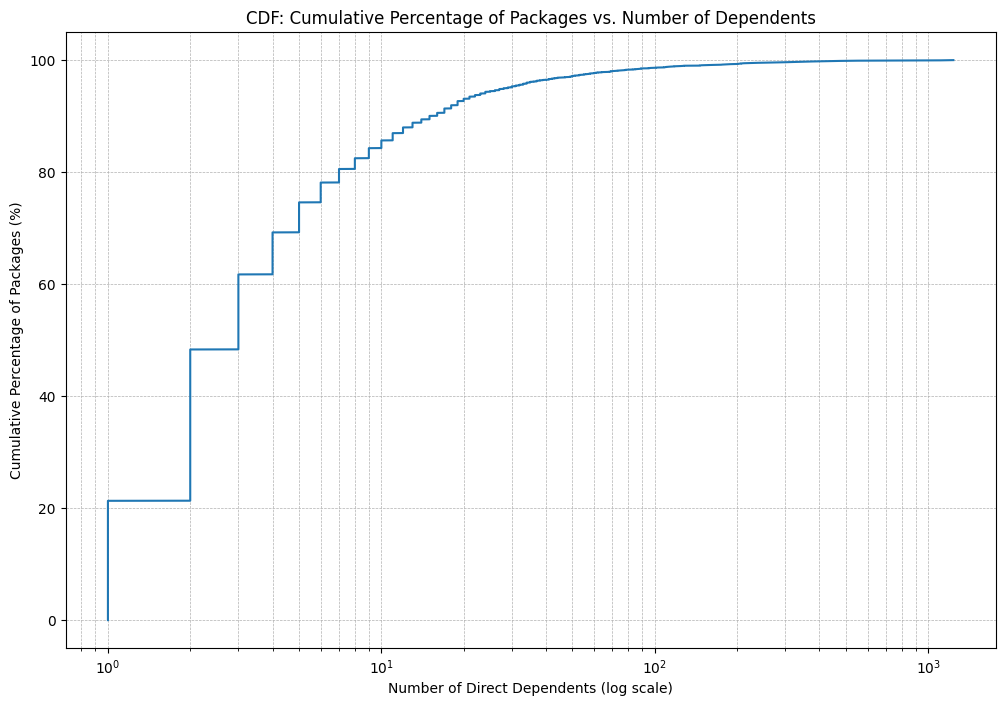

In [21]:
import numpy as np

# --- Create the CDF (Cumulative Distribution Function) ---

# Sort the number of dependents in ascending order
sorted_data = np.sort(dependents['num_direct_dependents'])

# Calculate the cumulative percentage for the y-axis
# This represents the percentage of packages that have a certain number of dependents or fewer
yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

# --- Plot the CDF ---
plt.figure(figsize=(12, 8))
# Use a log scale for the x-axis because the data is heavily skewed
plt.xscale('log')

# Plot the sorted number of dependents vs. their cumulative percentage
plt.plot(sorted_data, yvals)

# Add labels and a title for clarity
plt.xlabel("Number of Direct Dependents (log scale)")
plt.ylabel("Cumulative Percentage of Packages (%)")
plt.title("CDF: Cumulative Percentage of Packages vs. Number of Dependents")

# Add a grid to make it easier to read values
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Show the plot
plt.show()